<div class="alert alert-block alert-success">

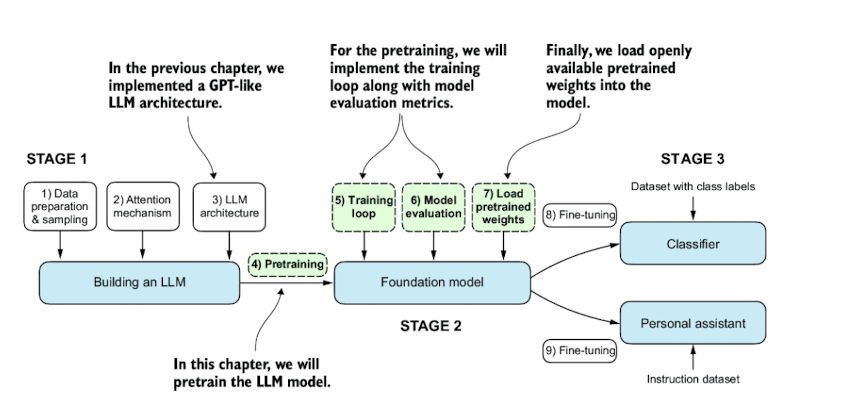

The three main stages of coding an LLM. We focus on stage 2: pretraining the LLM (step 4), which includes implementing the training code (step 5), evaluating the performance (step 6), and saving and loading model weights (step 7).

</div>

<div class="alert alert-block alert-info">

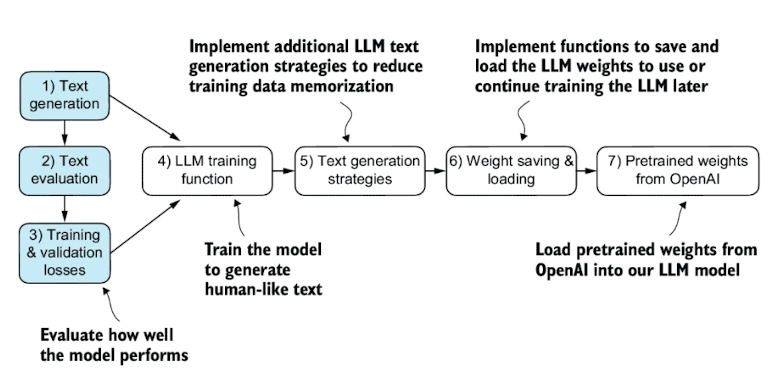

We begin by recapping text generation (step 1) before moving on to discuss basic model evaluation techniques (step 2) and training and validation losses (step 3).

</div>

## EVALUATING GENERATIVE TEXT MODELS

### GPT Model class we coded earlier

In [2]:
import torch
import torch.nn as nn


class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

In [3]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

In [4]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [6]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"], 
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size] #RETURNS CONTEXT
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x

In [7]:


class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        
        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])
        
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

In [8]:
import torch

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

<div class="alert alert-block alert-warning">
    
We reduce the context length (context_length) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

This is so that more readers will be able to follow and execute the code examples on their laptop computer
</div>

In [9]:
inputs = torch.tensor([[6109,  3626,  6100],   #["Every effort moves"]
                       [40, 1107, 588]])       #["I really like"]

# Matching the inputs we have the Target that we hope our model produces. 
# Loss function will analyze the predicted output with the true (target output) and we will try to minimize the loss function

target = torch.tensor([[3626,  6100, 345],   #["effort moves YOU "]
                       [1107, 588, 11311]])   #["really like chocolate"]


<div class="alert alert-block alert-success">

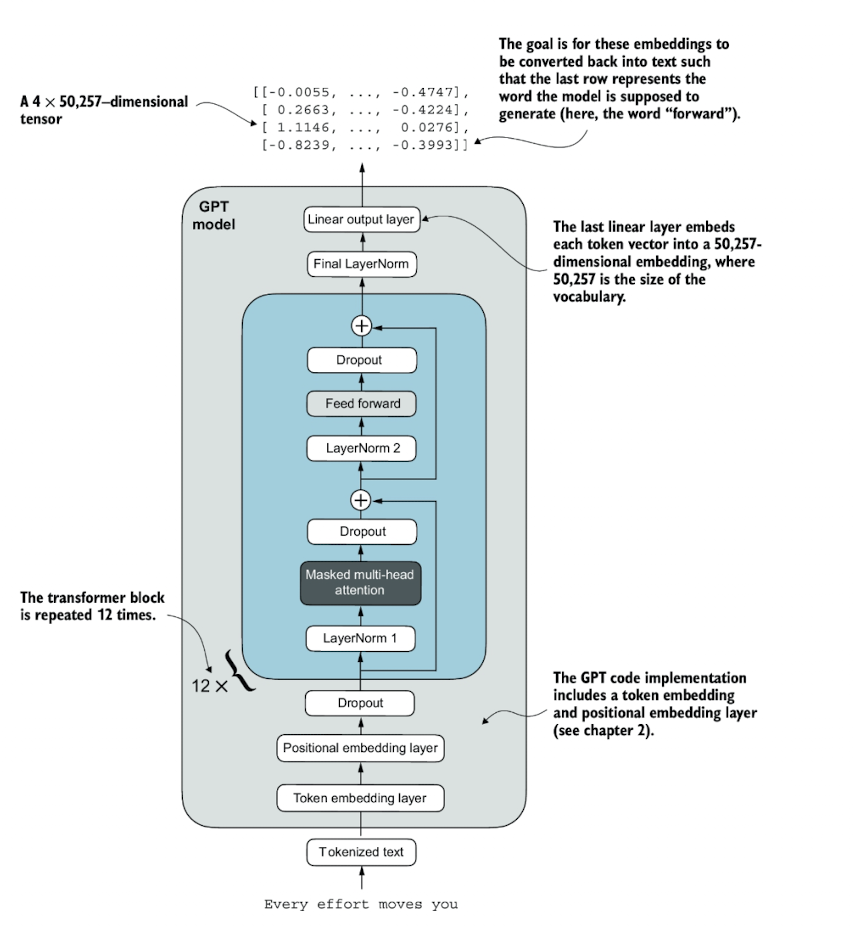
</div>

<div class="alert alert-block alert-info">

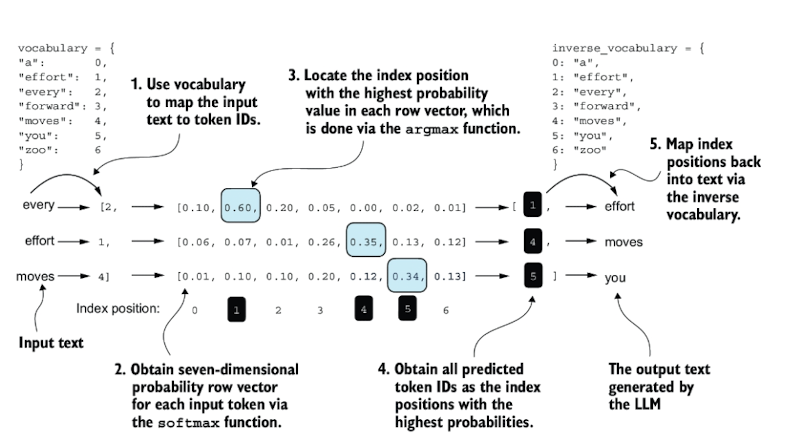
</div>

In [10]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "I really like chocolate"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

tensor([[ 6109,  3626,  6100,   345],
        [   40,  1107,   588, 11311]])


<div class="alert alert-block alert-success">
    
Next, we use the generate_text_simple function from the previous chapter to generate text.

In addition, we define two convenience functions, text_to_token_ids and token_ids_to_text, for converting between token and text representations that we use throughout this chapter

In [11]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [12]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


<div class="alert alert-block alert-info">

As we can see above, the model does not produce good text because it has not been trained yet

How do we measure or capture what "good text" is, in a numeric form, to track it during training?

The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress

The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

</div>

### Calculating the text generation loss: cross-entropy and perplexity

<div class="alert alert-block alert-info">

Suppose we have an inputs tensor containing the token IDs for 2 training examples (rows)

Corresponding to the inputs, the targets contain the desired token IDs that we want the model to generate

Notice that the targets are the inputs shifted by 1 position, as explained in chapter 2 when we implemented the data loader

</div>

In [13]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

<div class="alert alert-block alert-success">
    
Feeding the inputs to the model, we obtain the logits vector for the 2 input examples that consist of 3 tokens each

Each of the tokens is a 50,257-dimensional vector corresponding to the size of the vocabulary

Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

</div>

In [14]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


<div class="alert alert-block alert-warning">
    
As discussed in the previous chapter, we can apply the argmax function to convert the probability scores into predicted token IDs.

The softmax function above produced a 50,257-dimensional vector for each token; the argmax function returns the position of the highest probability score in this vector, which is the predicted token ID for the given token.

Since we have 2 input batches with 3 tokens each, we obtain 2 by 3 predicted token IDs:                                                                                                                                                                                         
</div>

In [15]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


<div class="alert alert-block alert-success">
    
If we decode these tokens, we find that these are quite different from the tokens we want the model to predict, namely the target tokens.

That's because the model wasn't trained yet.

To train the model, we need to know how far it is away from the correct predictions (targets)

</div>

In [16]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1:  Armed heNetflix


## Determining the lossfunction

<div class="alert alert-block alert-info">

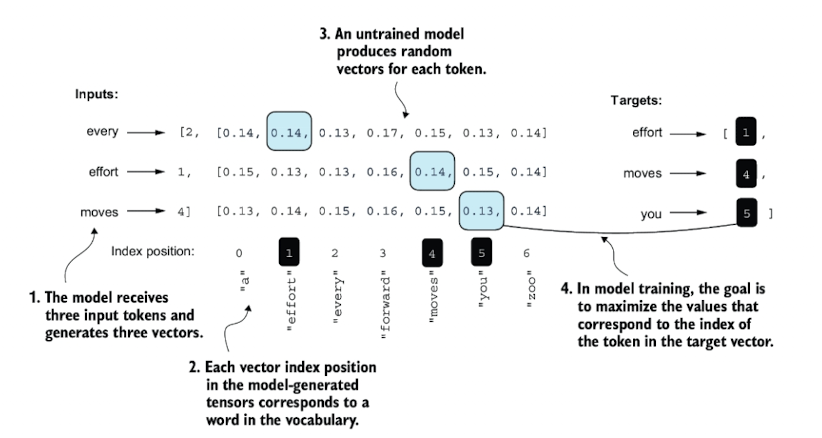

Before training, the model produces random next-token probability vectors. The goal of model training is to ensure that the probability values corresponding to the highlighted target token IDs are maximized.

We will take a look at the probabilities of the target vectors

batch 1 [[3626, 6100, 345  ]  -> get index [i11, i12, i13] -> get probability at this index [p11, p12, p13] # [" effort moves you"] 

batch 2 [1107,  588, 11311]]) -> get index  [i21,i22,i23]  -> get probability at this index [p21,p22, p23]   # ["really like chocolate"]

goal of our training is to get these probability values to be as close to 1 as possible

merging them we get [p11,p12, p13, p21, p22, p23 ]

</div>

<div class="alert alert-block alert-success">

How can we maximize this probablility 

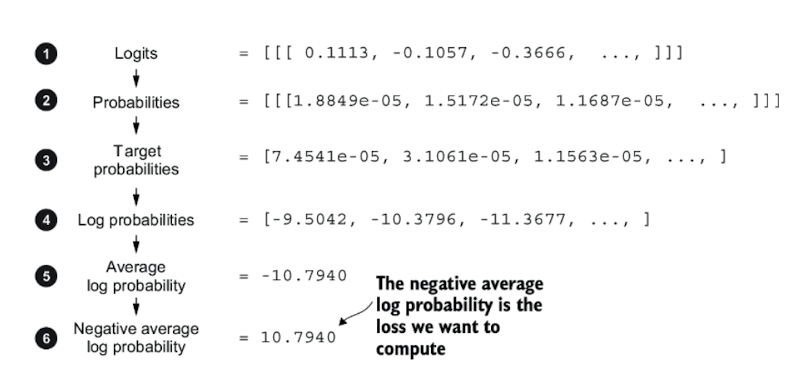


Calculating the loss involves several steps. Steps 1 to 3, which we have already completed, calculate the token probabilities corresponding to the target tensors. These probabilities are then transformed via a logarithm and averaged in steps 4 to 6.

This is the cross entropy loss and we want to minimize this loss.

Mathematically 

The formula for the loss is:
$$Loss = - \frac{1}{n} \sum_{i=1}^{n} \log(p_i)$$
where $n$ is the context length and $p_i$ is the predicted probability for each target token $i$.

We want to make sure that loss is nealry equal to 0. This is possilbe only if each probability is close to 1 - log1 = 0


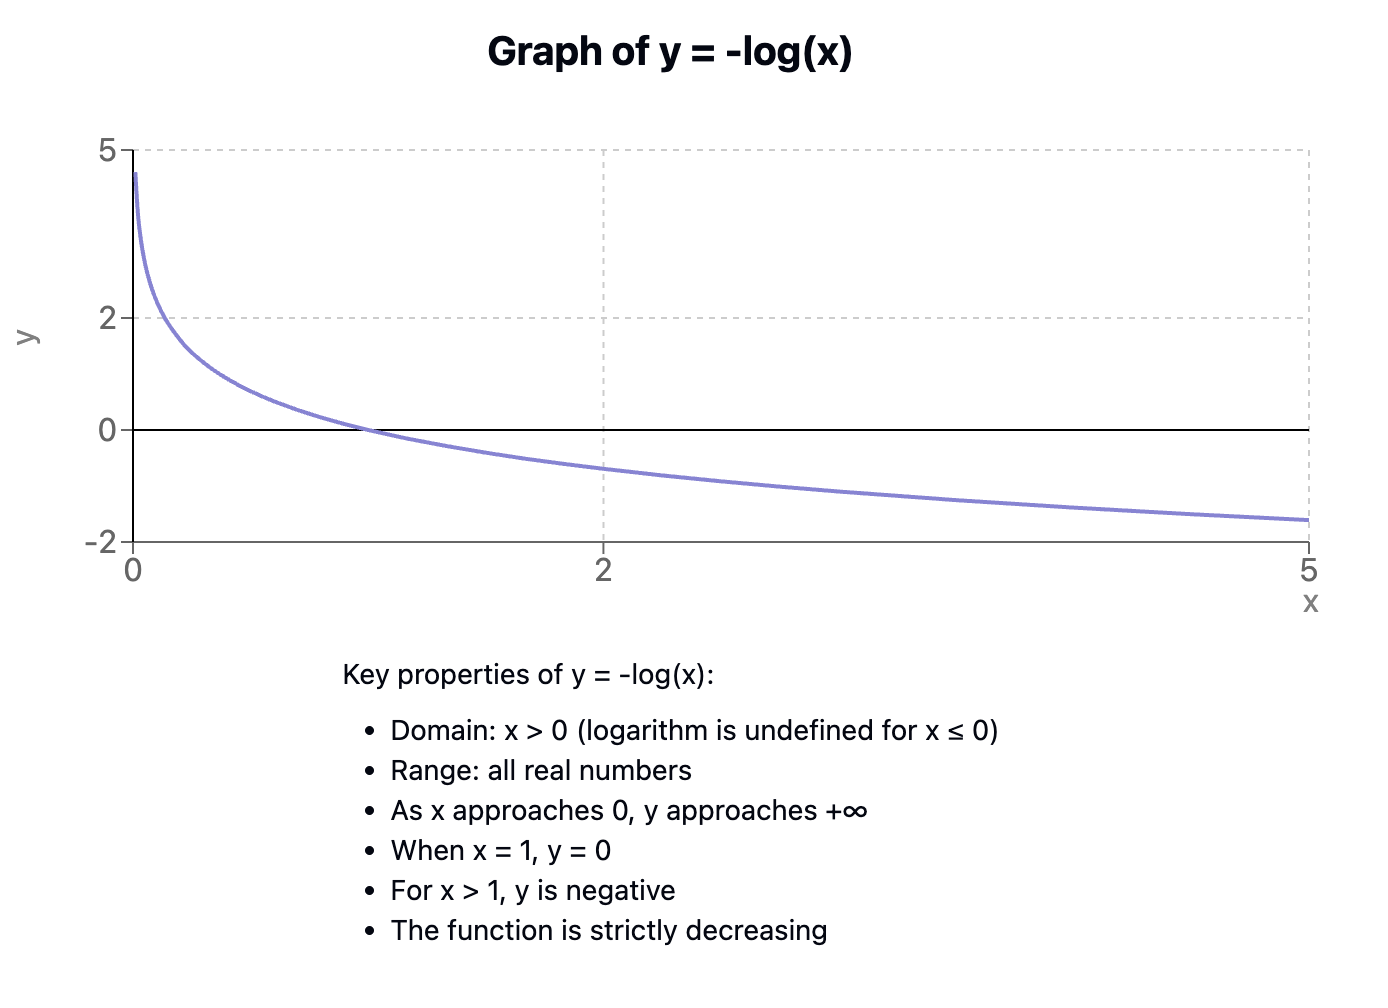

</div>

### Cross-entropy loss

<div class="alert alert-block alert-success">

The token probabilities corresponding to the target indices are as follows:

</div>

In [17]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


<div class="alert alert-block alert-warning">

We want to maximize all these values, bringing them close to a probability of 1.
    
In mathematical optimization, it is easier to maximize the logarithm of the probability score than the probability score itself.

</div>

In [18]:
# Compute logarithm of all token probabilities
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


<div class="alert alert-block alert-success">

Next, we compute the average log probability:
</div>

In [19]:
# Calculate the average probability for each token
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


<div class="alert alert-block alert-success">

PyTorch already implements a cross_entropy function that carries out the previous steps

Before we apply the cross_entropy function, let's check the shape of the logits and targets

</div>

In [20]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


<div class="alert alert-block alert-success">

For the cross_entropy function in PyTorch, we want to flatten these tensors by combining them over the batch dimension:

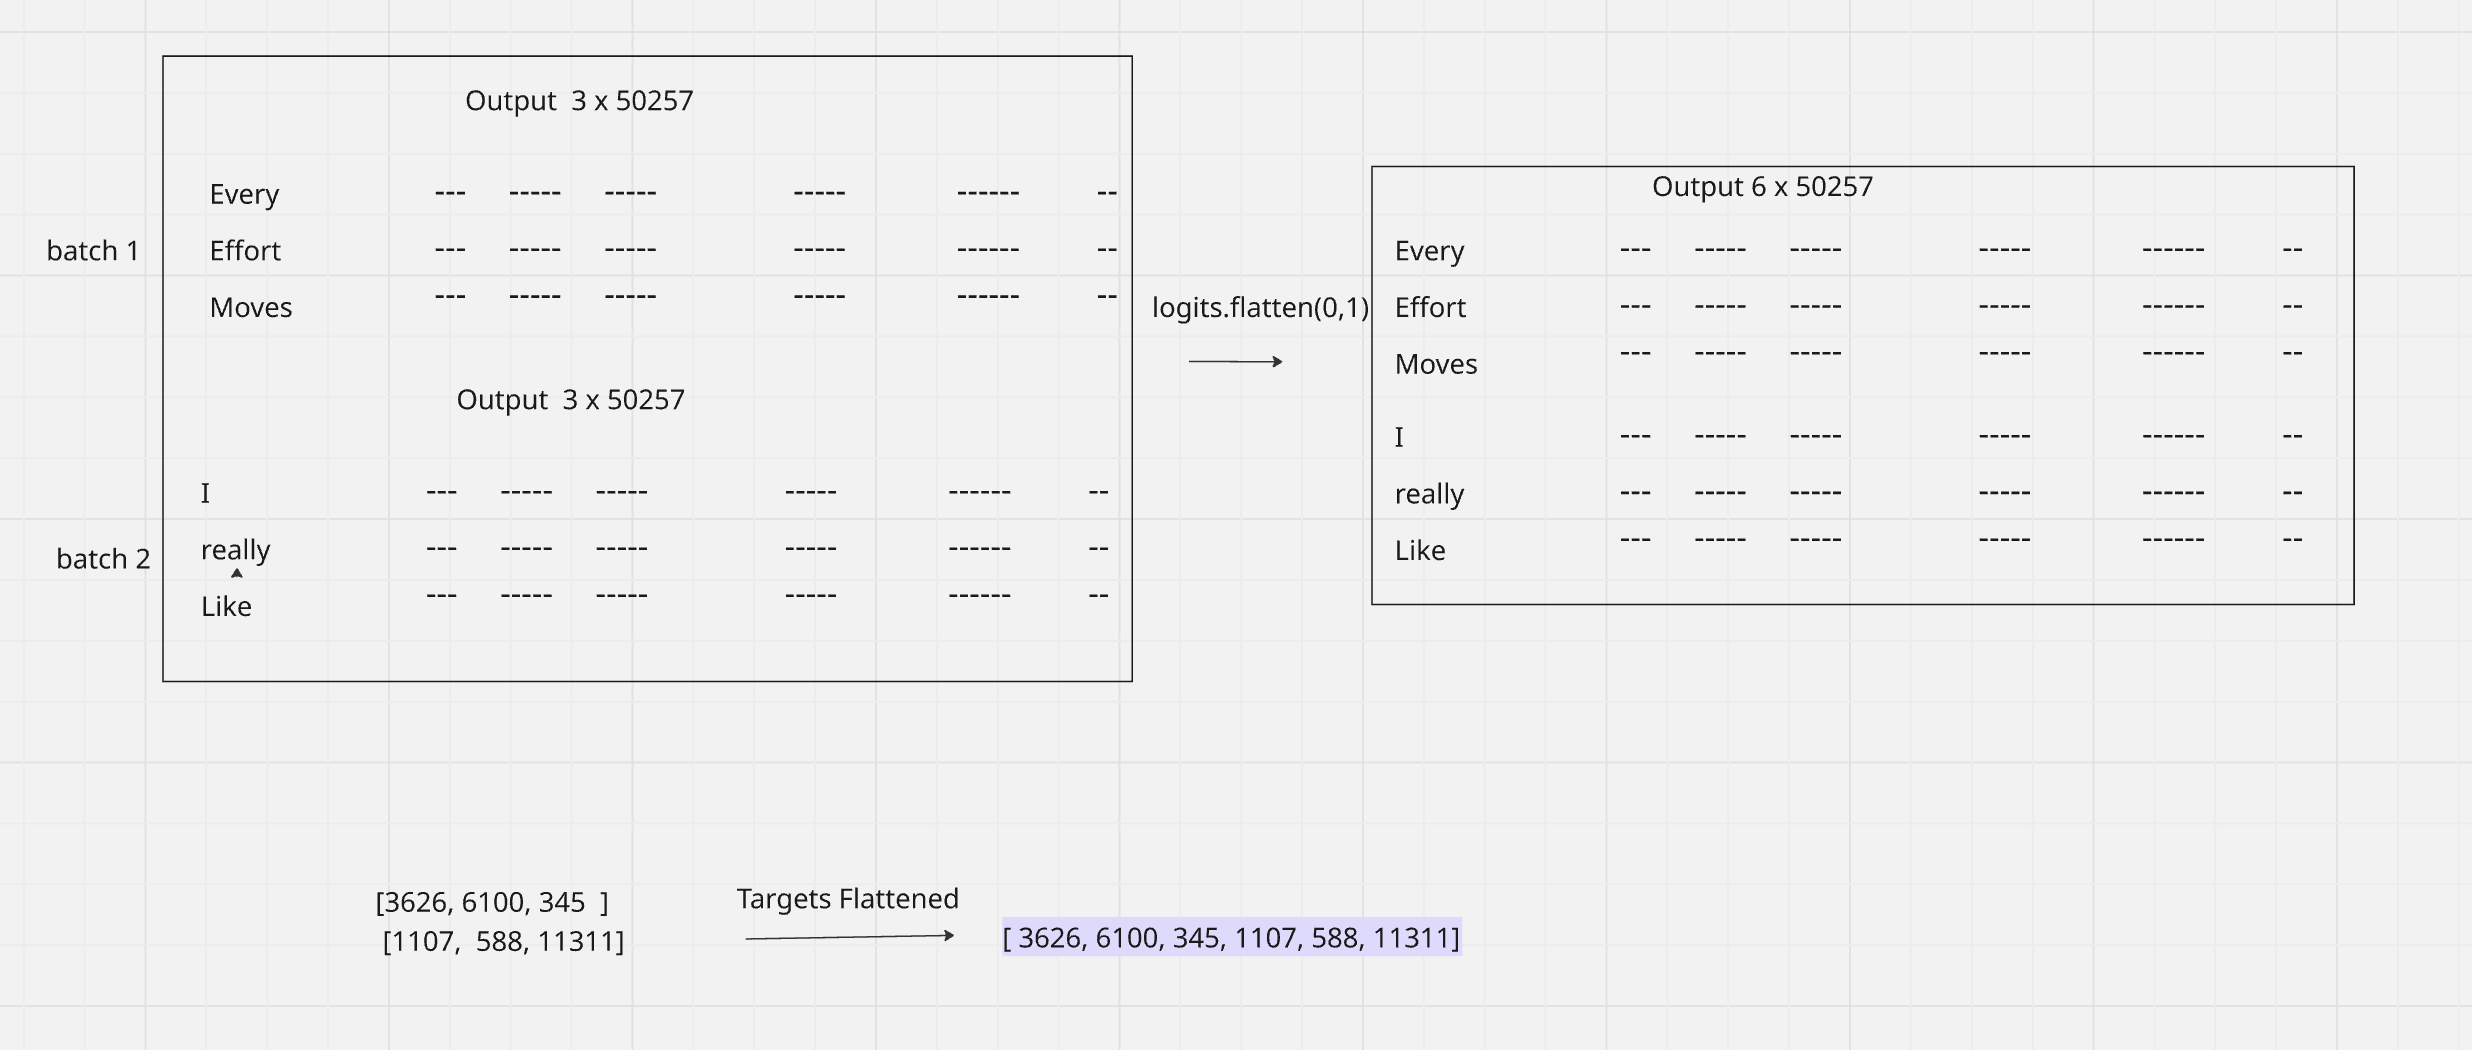

</div>

In [21]:
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


<div class="alert alert-block alert-info">

Note that the targets are the token IDs, which also represent the index positions in the logits tensors that we want to maximize.
    
The cross_entropy function in PyTorch will automatically take care of applying the softmax and log-probability computation internally over those token indices in the logits that are to be maximized

</div>

In [22]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


### Perplexity

<div class="alert alert-block alert-success">

A concept related to the cross-entropy loss is the perplexity of an LLM. It measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.

The perplexity is simply the exponential of the cross-entropy loss. Lower the perplexity - better is result

</div>

In [23]:
perplexity = torch.exp(loss)
print(perplexity)

tensor(48725.8203)


<div class="alert alert-block alert-info">

The perplexity is often considered more interpretable because it can be understood as the effective vocabulary size that the model is uncertain about at each step (in the example above, that'd be 48,725 words or tokens).

In other words, perplexity provides a measure of how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset.
    
Similar to the loss, a lower perplexity indicates that the model predictions are closer to the actual distribution
    
</div>